In [1]:
%matplotlib inline

# MNIST template

## Tarea 4

Este archivo permite cargar el set de datos MNIST para ser usado con scikit-learn.

Puede usarlo como base para entrenar sus modelos, la selección de modelos.  No olvide guardar sus modelos en un archivo para utilizar los mejores de ellos en ``predict_digit.ipynb``.

MNIST es un set de datos bastante utilizado, y existen múltiples posibilidades de cargarlo en programas de Python.

- Usando ``fetch_openml`` de ``sckit-learn`` es una opción pero tiene en algunas versiones el problema de que baja todo el conjunto de internet cada vez que se ejecuta el programa, lo que no lo hace viable.
- Usando el paquete ``python-mnist``, que no existe en las distribuciones de conda
- Usando el paquete ``mnist``
- Usando ``pandas``

Aquí usaremos la versión que usa el paquete ``mnist``, para evitar dependencias adicionales a bibliotecas grandes.

Dicho paquete carga los datos como un tensor de 60000x28x28, es decir, 60000 imágenes de 28x28 dimensiones.  Cada pixel es de tipo entero sin signo de 8 bits.

In [2]:
# Si le falta la biblioteca 'mnist' y usa Anaconda:
#!conda install mnist

# o cualquier otra distribución de Python:
#!pip install mnist

In [3]:
import mnist
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import time
from pathlib import Path

In [4]:
tic=time.time()

# Asegure que el directorio de datos existe.
datadir='./mnist_data/'
Path(datadir).mkdir(parents=False, exist_ok=True)

# temporary_dir es una función que retorna el directorio temporal;
mnist.temporary_dir = lambda: datadir

# Prepare el codificador 'one-hot'
enc = OneHotEncoder(handle_unknown='ignore')

# La primera vez, esto puede tardar unos segundos a minutos por tener
# que bajar los datos originales de internet.
# Después de eso debería ser rápido.

# Prepare los datos de entrenamiento
train_images = mnist.train_images() # Esto es un tensor m x 28 x 28
train_labels = mnist.train_labels().astype(int)
train_ohelab = enc.fit_transform(train_labels.reshape(-1,1)).toarray() # labels one-hot encoded

m,h,w=train_images.shape
train_data = train_images.reshape((m,w*h)).astype(float)/255 # Esto es una matrix de m x 784

# Prepare los datos de validación
val_images = mnist.test_images() # Esto es un tensor de m x 28 x 28
val_labels = mnist.test_labels().astype(int)
val_ohelab = enc.transform(val_labels.reshape(-1,1)).toarray()

vm,vh,vw=val_images.shape
val_data = val_images.reshape((vm,vw*vh)).astype(float)/255 # Esto es una matrix de m x 784


toc=time.time()-tic
print("Tardó: {0} s".format(toc))

print("Entrenamiento: {0} datos de {1}x{2} dimensiones".format(m,h,w))
print("Validación   : {0} datos de {1}x{2} dimensiones".format(vm,vh,vw))

Tardó: 1.217297077178955 s
Entrenamiento: 60000 datos de 28x28 dimensiones
Validación   : 10000 datos de 28x28 dimensiones


A este punto, se cuenta con la siguiente información para poder entrenar:

- train_data: arreglo de 60000 datos de 784 dimensiones
- train_label: vector de 60000 etiquetas como enteros entre 0 y 9
- train_ohelab: arreglo de 60000x10 con la codificación de las etiquetas _one-hot_
- val_data: arreglo de 10000 datos de 784 dimensiones
- val_label: vector de 10000 etiquetas como enteros entre 0 y 9
- val_ohelab: arreglo de 10000x10 con la codificación de las etiquetas _one-hot_


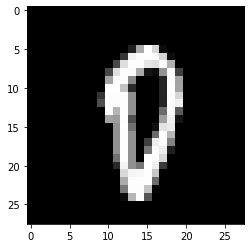

Etiqueta entera: 0
         one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


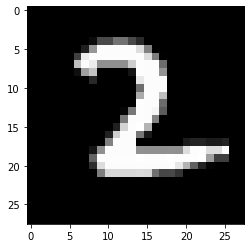

Etiqueta entera: 2
         one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


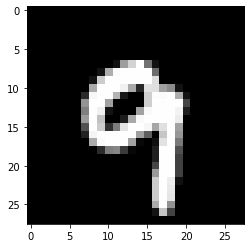

Etiqueta entera: 9
         one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


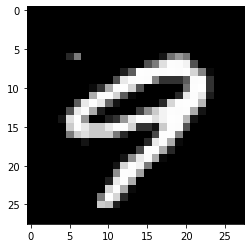

Etiqueta entera: 9
         one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
# Muestre algunas muestras
samples = np.random.choice(np.arange(m),4,replace=False)

for i in samples:
    plt.imshow(train_data[i].reshape((28,28)),cmap='gray')
    plt.show()

    print("Etiqueta entera:",train_labels[i])
    print("         one-hot:",train_ohelab[i])


## Entrenar/seleccionar modelos

A continuación usted debe entrenar y seleccionar los modelos, y guardar el mejor de ellos para cada tipo (SVM, RDF, kNN)

In [6]:
A=list(range(1,6,1))
B=list(range(10,51,10))
A += B
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': A,'weights': ['distance']},{'n_neighbors': A,'weights': ['uniform']}]

scores = ['precision', 'recall']

{'n_neighbors': 1, 'weights': 'distance'}
{'n_neighbors': 2, 'weights': 'distance'}
{'n_neighbors': 3, 'weights': 'distance'}
{'n_neighbors': 4, 'weights': 'distance'}
{'n_neighbors': 5, 'weights': 'distance'}
{'n_neighbors': 10, 'weights': 'distance'}
{'n_neighbors': 20, 'weights': 'distance'}
{'n_neighbors': 30, 'weights': 'distance'}
{'n_neighbors': 40, 'weights': 'distance'}
{'n_neighbors': 50, 'weights': 'distance'}
{'n_neighbors': 1, 'weights': 'uniform'}
{'n_neighbors': 2, 'weights': 'uniform'}
{'n_neighbors': 3, 'weights': 'uniform'}
{'n_neighbors': 4, 'weights': 'uniform'}
{'n_neighbors': 5, 'weights': 'uniform'}
{'n_neighbors': 10, 'weights': 'uniform'}
{'n_neighbors': 20, 'weights': 'uniform'}
{'n_neighbors': 30, 'weights': 'uniform'}
{'n_neighbors': 40, 'weights': 'uniform'}
{'n_neighbors': 50, 'weights': 'uniform'}


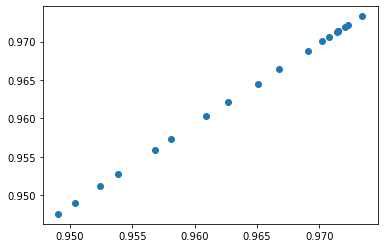

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score,recall_score

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

# Crear una lista con las combinaciones deseadas de parámetros
grid = ParameterGrid(tuned_parameters)

N_FOLD=5
RANDOM_SEED=42

# Preparar particionador de los datos
cv = KFold(n_splits=N_FOLD, shuffle=True, random_state=RANDOM_SEED)

precisions,recalls=[],[]

for params in grid:
    classifier = KNeighborsClassifier(**params)
    print(params)
    precision,recall=0,0
    for train_index, test_index in cv.split(train_data):
        cX_train, cX_test = train_data[train_index], train_data[test_index]
        cy_train, cy_test = train_labels[train_index], train_labels[test_index]

        classifier.fit(cX_train,cy_train)
        y_predicted=classifier.predict(cX_test)
        
        precision+=precision_score(cy_test,y_predicted,average='weighted')
        recall+=recall_score(cy_test,y_predicted,average='weighted')
        
    precision/=N_FOLD
    recall/=N_FOLD
    
    precisions.append(precision)
    recalls.append(recall)

plt.figure();
plt.scatter(precisions,recalls)


In [12]:
##La asignación de los mejores parámetros se hizo de forma manual,
##ya que visualmente se pudo ver como hay un parámetro que tiene mayor precision y recall.

##El código utilizado para determinar cual índice es el que contiene el mejor parámetro es el siguiente:
# tmp = max(recalls)
# index = recalls.index(tmp)
# print(index)
# print(recalls)

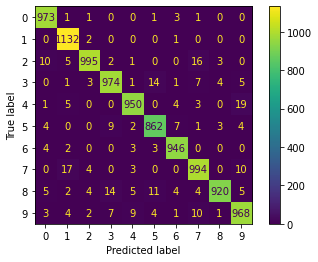

In [13]:
#una vez definido el mejor parámetro, se entrena nuevamente con dicho parámetro y se carga la red entrenada
#además, se obtiene la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

kNNClassifier = KNeighborsClassifier(n_neighbors= 4, weights = 'distance')

kNNClassifier.fit(train_data,train_labels)
y_predicted=kNNClassifier.predict(val_data)

cm = confusion_matrix(val_labels, y_predicted)
cm_display = ConfusionMatrixDisplay(cm).plot()
    

In [14]:
from joblib import dump, load

dump(kNNClassifier,"knnclass.joblib")

['knnclass.joblib']